# Using Big Data Analytics to analyze and identify patterns storm events across different states and territories of USA for year 2022

**Member 1: Priyanka Bhatta, 2060036**

**Member 2: Subina Shrestha, 2059756**

## Data Loading, Cleaning, and Exploration

In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Priyanka\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
from pyspark.sql import SparkSession

In [3]:
# Create a SparkSession
spark = SparkSession.builder.appName("StormEvents2022USA").getOrCreate()

#### loading the CSV file into a pandas dataframe named 'data'.

In [4]:
# Load the CSV file
data = spark.read.csv("StormEvents_details_1.csv", header=True, inferSchema=True)

In [5]:
# Checking the first five rows
data.show(5)

+---------------+---------+----------+-------------+-------+--------+----------+--------+--------------+----------+----+----------+----------+-------+-------+--------------------+---+---------------+-----------+---------------+---------------+-----------------+-------------+---------------+---------------+------------+--------------------+---------+--------------+-----------+--------+-----------+----------+---------+-------------+------------------+-----------------+-----------------+-----------+-------------+--------------+---------+-----------+------------+---------+---------+--------+---------+--------------------+--------------------+-----------+
|BEGIN_YEARMONTH|BEGIN_DAY|BEGIN_TIME|END_YEARMONTH|END_DAY|END_TIME|EPISODE_ID|EVENT_ID|         STATE|STATE_FIPS|YEAR|MONTH_NAME|EVENT_TYPE|CZ_TYPE|CZ_FIPS|             CZ_NAME|WFO|BEGIN_DATE_TIME|CZ_TIMEZONE|  END_DATE_TIME|INJURIES_DIRECT|INJURIES_INDIRECT|DEATHS_DIRECT|DEATHS_INDIRECT|DAMAGE_PROPERTY|DAMAGE_CROPS|              SOURCE|

**Checking the schema:**

In [6]:
data.printSchema()

root
 |-- BEGIN_YEARMONTH: integer (nullable = true)
 |-- BEGIN_DAY: integer (nullable = true)
 |-- BEGIN_TIME: integer (nullable = true)
 |-- END_YEARMONTH: integer (nullable = true)
 |-- END_DAY: integer (nullable = true)
 |-- END_TIME: integer (nullable = true)
 |-- EPISODE_ID: integer (nullable = true)
 |-- EVENT_ID: integer (nullable = true)
 |-- STATE: string (nullable = true)
 |-- STATE_FIPS: integer (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH_NAME: string (nullable = true)
 |-- EVENT_TYPE: string (nullable = true)
 |-- CZ_TYPE: string (nullable = true)
 |-- CZ_FIPS: integer (nullable = true)
 |-- CZ_NAME: string (nullable = true)
 |-- WFO: string (nullable = true)
 |-- BEGIN_DATE_TIME: string (nullable = true)
 |-- CZ_TIMEZONE: string (nullable = true)
 |-- END_DATE_TIME: string (nullable = true)
 |-- INJURIES_DIRECT: integer (nullable = true)
 |-- INJURIES_INDIRECT: integer (nullable = true)
 |-- DEATHS_DIRECT: integer (nullable = true)
 |-- DEATHS_INDIRE

#### Provides summary statistics for numerical columns

In [7]:
data.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-------+------------------+------+----------+--------------------+-------+------------------+--------------------+-----+---------------+-----------+-------------+--------------------+--------------------+--------------------+--------------------+---------------+------------+---------------+------------------+--------------+-------------------+------------------+-----------+------------------+------------------+-------------+------------------+------------------+-----------------+-----------------+-------------+------------------+-----------------+-----------+------------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+-----------+
|summary|   BEGIN_YEARMONTH|         BEGIN_DAY|        BEGIN_TIME|     END_YEARMONTH|          END_DAY|          END_TIME|      

**Checking number of rows and columns**

In [8]:
num_rows = data.count()  # Number of rows
num_cols = len(data.columns)  # Number of columns

print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 68703
Number of columns: 51


In [9]:
from pyspark.sql.functions import col, sum as spark_sum

# Calculate the count of null values in each column
null_counts = data.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])

# Show the count of null values in each column
null_counts.show()


+---------------+---------+----------+-------------+-------+--------+----------+--------+-----+----------+----+----------+----------+-------+-------+-------+---+---------------+-----------+-------------+---------------+-----------------+-------------+---------------+---------------+------------+------+---------+--------------+-----------+--------+-----------+----------+---------+-------------+------------------+-----------------+-----------------+-----------+-------------+--------------+---------+-----------+------------+---------+---------+-------+-------+-----------------+---------------+-----------+
|BEGIN_YEARMONTH|BEGIN_DAY|BEGIN_TIME|END_YEARMONTH|END_DAY|END_TIME|EPISODE_ID|EVENT_ID|STATE|STATE_FIPS|YEAR|MONTH_NAME|EVENT_TYPE|CZ_TYPE|CZ_FIPS|CZ_NAME|WFO|BEGIN_DATE_TIME|CZ_TIMEZONE|END_DATE_TIME|INJURIES_DIRECT|INJURIES_INDIRECT|DEATHS_DIRECT|DEATHS_INDIRECT|DAMAGE_PROPERTY|DAMAGE_CROPS|SOURCE|MAGNITUDE|MAGNITUDE_TYPE|FLOOD_CAUSE|CATEGORY|TOR_F_SCALE|TOR_LENGTH|TOR_WIDTH|TOR_OTHE

**Let's drop all the unnecessary columns**

In [10]:
columns_to_drop = ['CZ_TYPE', 'EPISODE_ID', 'CATEGORY', 'TOR_LENGTH', 'TOR_WIDTH', 'STATE_FIPS', 'CZ_FIPS', 'CZ_NAME', 'TOR_OTHER_WFO', 'TOR_F_SCALE', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE', 'CZ_FIPS', 'WFO', 'BEGIN_AZIMUTH', 'END_RANGE', 'END_AZIMUTH', 'DATA_SOURCE']
data = data.drop(*columns_to_drop)

#### Checking the number of columns left after dropping un-important columns

In [11]:
num_columns = len(data.columns)
print("Number of columns:", num_columns)

Number of columns: 32


In [12]:
# Check the column names of the DataFrame
column_names = data.columns

# Print the column names
for column in column_names:
    print(column)


BEGIN_YEARMONTH
BEGIN_DAY
BEGIN_TIME
END_YEARMONTH
END_DAY
END_TIME
EVENT_ID
STATE
YEAR
MONTH_NAME
EVENT_TYPE
BEGIN_DATE_TIME
CZ_TIMEZONE
END_DATE_TIME
INJURIES_DIRECT
INJURIES_INDIRECT
DEATHS_DIRECT
DEATHS_INDIRECT
DAMAGE_PROPERTY
DAMAGE_CROPS
SOURCE
MAGNITUDE
MAGNITUDE_TYPE
FLOOD_CAUSE
BEGIN_LOCATION
END_LOCATION
BEGIN_LAT
BEGIN_LON
END_LAT
END_LON
EPISODE_NARRATIVE
EVENT_NARRATIVE


**Check for duplicate rows in the dataset**

In [13]:
duplicate_rows = data.dropDuplicates()
has_duplicates = duplicate_rows.count() > data.count()

if has_duplicates:
    print("There are duplicate rows in the dataset.")
else:
    print("There are no duplicate rows in the dataset.")

There are no duplicate rows in the dataset.


## DATA ANALYSIS AND VISUALIZATION

In [14]:
from pyspark.sql.functions import count
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Group by state and count the number of events
events_by_state = data.groupBy('STATE').agg(count('*').alias('count'))

# Sort in descending order and get top 10
window_spec = Window.orderBy(F.desc('count'))
top_10_states = events_by_state.withColumn('rank', F.rank().over(window_spec)).filter(F.col('rank') <= 10)

# Show the results
top_10_states.show()

+------------+-----+----+
|       STATE|count|rank|
+------------+-----+----+
|       TEXAS| 5412|   1|
|SOUTH DAKOTA| 2741|   2|
|   MINNESOTA| 2728|   3|
|  CALIFORNIA| 2668|   4|
|      KANSAS| 2321|   5|
|    NEBRASKA| 2195|   6|
|    ILLINOIS| 2181|   7|
|    OKLAHOMA| 2077|   8|
|    KENTUCKY| 2068|   9|
|    VIRGINIA| 2017|  10|
+------------+-----+----+



In [15]:
# Count the number of storm events by state and event type
counts = data.groupBy('STATE', 'EVENT_TYPE').agg(count('*').alias('count'))

# Print the resulting counts
counts.show()

+-----------+----------------+-----+
|      STATE|      EVENT_TYPE|count|
+-----------+----------------+-----+
|   COLORADO|      Dust Storm|   16|
| NEW MEXICO|            Hail|   59|
|   OKLAHOMA|       High Wind|   81|
|   NEBRASKA|  Winter Weather|   59|
|    WYOMING| Cold/Wind Chill|    7|
| NEW JERSEY|       Ice Storm|    1|
|MISSISSIPPI|            Heat|  153|
|CONNECTICUT|       Lightning|    1|
|     KANSAS|      Dust Storm|   45|
| CALIFORNIA|    Funnel Cloud|    3|
|  TENNESSEE|            Hail|  130|
|      TEXAS|    Winter Storm|   75|
| WASHINGTON|       Avalanche|    2|
|     KANSAS|         Drought|  351|
|    GEORGIA|       High Wind|    2|
|  WISCONSIN|       High Wind|   10|
|    FLORIDA|      Heavy Rain|   69|
|  WISCONSIN|Lake-Effect Snow|    2|
|  TENNESSEE|      Heavy Rain|    9|
|   ILLINOIS|           Sleet|   13|
+-----------+----------------+-----+
only showing top 20 rows



In [16]:
from pyspark.sql.functions import avg, min, max

print("INJURIES_DIRECT stats:")
data.select(min("INJURIES_DIRECT").alias("Minimum injuries"),
            max("INJURIES_DIRECT").alias("Maximum injuries"),
            avg("INJURIES_DIRECT").alias("Average injuries")
            ).show()

print("\nINJURIES_INDIRECT stats:")
data.select(min("INJURIES_INDIRECT").alias("Minimum injuries"),
            max("INJURIES_INDIRECT").alias("Maximum injuries"),
            avg("INJURIES_INDIRECT").alias("Average injuries")
            ).show()

print("\nDEATHS_DIRECT stats:")
data.select(min("DEATHS_DIRECT").alias("Minimum deaths"),
            max("DEATHS_DIRECT").alias("Maximum deaths"),
            avg("DEATHS_DIRECT").alias("Average deaths")
            ).show()

print("\nDEATHS_INDIRECT stats:")
data.select(min("DEATHS_INDIRECT").alias("Minimum deaths"),
            max("DEATHS_INDIRECT").alias("Maximum deaths"),
            avg("DEATHS_INDIRECT").alias("Average deaths")
            ).show()

INJURIES_DIRECT stats:
+----------------+----------------+--------------------+
|Minimum injuries|Maximum injuries|    Average injuries|
+----------------+----------------+--------------------+
|               0|             350|0.016462163224313348|
+----------------+----------------+--------------------+


INJURIES_INDIRECT stats:
+----------------+----------------+--------------------+
|Minimum injuries|Maximum injuries|    Average injuries|
+----------------+----------------+--------------------+
|               0|              34|0.006156936378324091|
+----------------+----------------+--------------------+


DEATHS_DIRECT stats:
+--------------+--------------+--------------------+
|Minimum deaths|Maximum deaths|      Average deaths|
+--------------+--------------+--------------------+
|             0|            60|0.008806020115569918|
+--------------+--------------+--------------------+


DEATHS_INDIRECT stats:
+--------------+--------------+--------------------+
|Minimum death

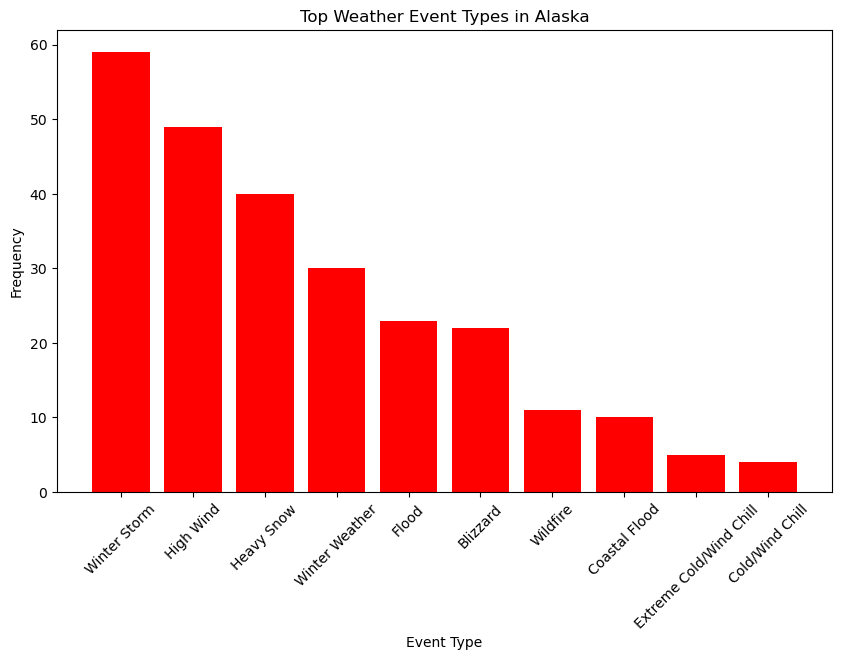

In [17]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Filter data for Alaska
alaska_data = data.filter(col("STATE") == "ALASKA")

# Group by event type and count occurrences
event_counts = alaska_data.groupby("EVENT_TYPE").count()

# Sort by count in descending order
event_counts = event_counts.orderBy(col("count").desc())

# Take top 10 event types
top_10_event_counts = event_counts.limit(10)

# Convert to Pandas DataFrame for visualization
top_10_event_counts_df = top_10_event_counts.toPandas()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_event_counts_df["EVENT_TYPE"], top_10_event_counts_df["count"], color='r')
plt.title("Top Weather Event Types in Alaska")
plt.xlabel("Event Type")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


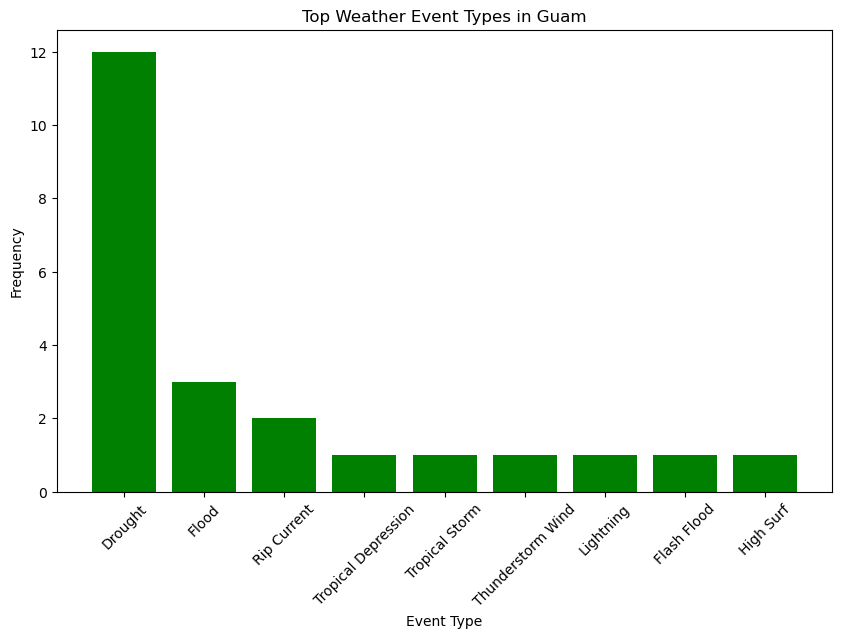

In [18]:
# Filter data for Guam
guam_data = data.filter(col("STATE") == "GUAM")

# Group by event type and count occurrences
event_counts = guam_data.groupby("EVENT_TYPE").count()

# Sort by count in descending order
event_counts = event_counts.orderBy(col("count").desc())

# Take top 10 event types
top_10_event_counts = event_counts.limit(10)

# Convert to Pandas DataFrame for visualization
top_10_event_counts_df = top_10_event_counts.toPandas()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_event_counts_df["EVENT_TYPE"], top_10_event_counts_df["count"], color='g')
plt.title("Top Weather Event Types in Guam")
plt.xlabel("Event Type")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

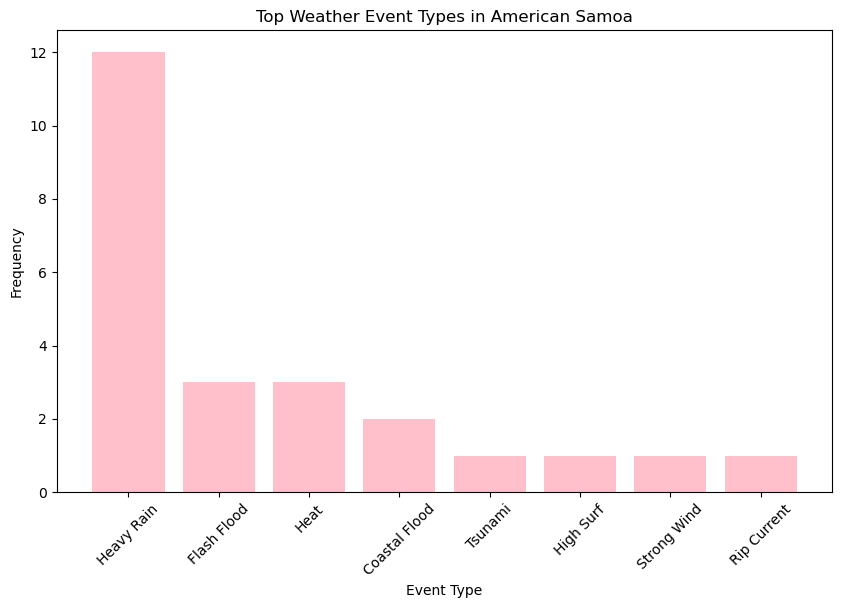

In [19]:
# Filter data for American Samoa
as_data = data.filter(col("STATE") == "AMERICAN SAMOA")

# Group by event type and count occurrences
event_counts = as_data.groupby("EVENT_TYPE").count()

# Sort by count in descending order
event_counts = event_counts.orderBy(col("count").desc())

# Take top 10 event types
top_10_event_counts = event_counts.limit(10)

# Convert to Pandas DataFrame for visualization
top_10_event_counts_df = top_10_event_counts.toPandas()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_event_counts_df["EVENT_TYPE"], top_10_event_counts_df["count"], color='pink')
plt.title("Top Weather Event Types in American Samoa")
plt.xlabel("Event Type")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

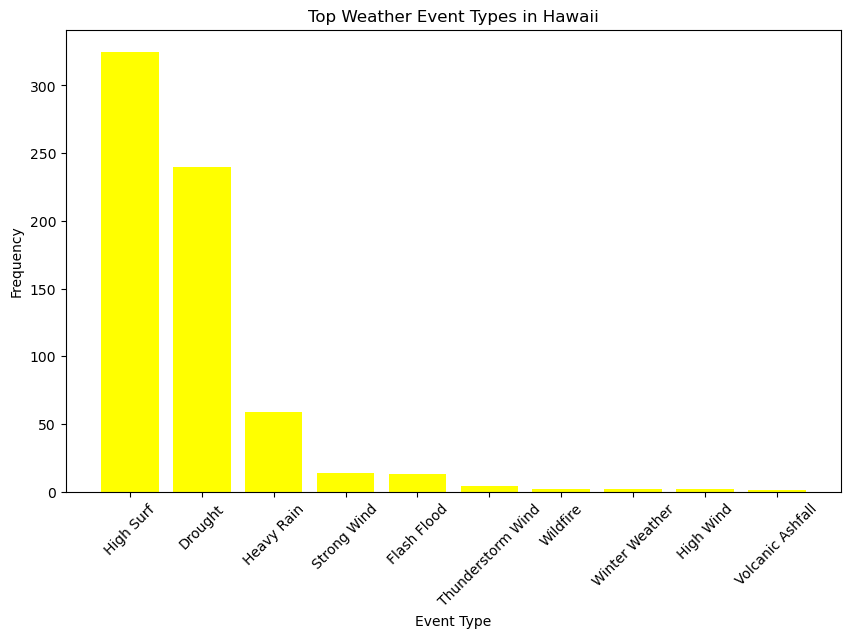

In [20]:
# Filter data for Hawaii
hawaii_data = data.filter(col("STATE") == "HAWAII")

# Group by event type and count occurrences
event_counts = hawaii_data.groupby("EVENT_TYPE").count()

# Sort by count in descending order
event_counts = event_counts.orderBy(col("count").desc())

# Take top 10 event types
top_10_event_counts = event_counts.limit(10)

# Convert to Pandas DataFrame for visualization
top_10_event_counts_df = top_10_event_counts.toPandas()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_event_counts_df["EVENT_TYPE"], top_10_event_counts_df["count"], color='yellow')
plt.title("Top Weather Event Types in Hawaii")
plt.xlabel("Event Type")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


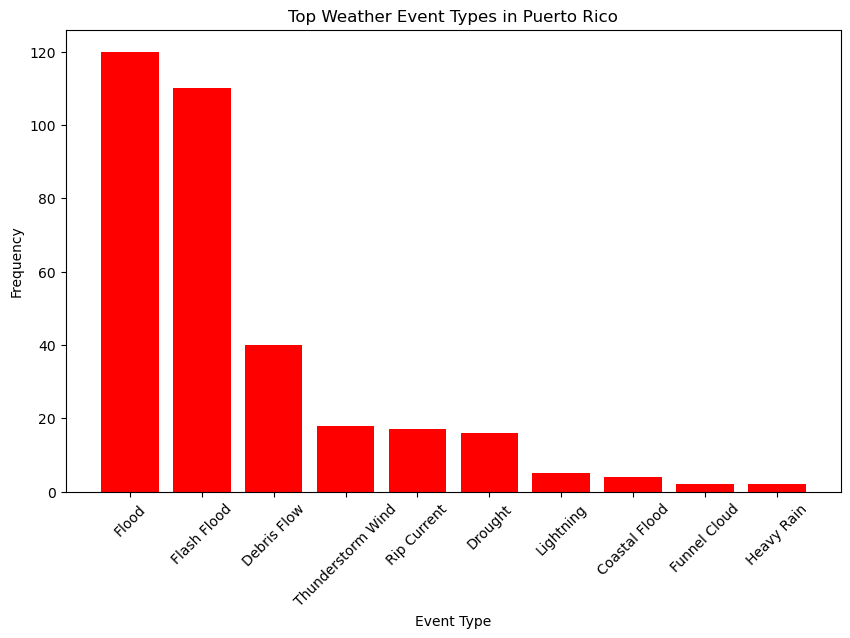

In [21]:
# Filter data for Puerto Rico
pr_data = data.filter(col("STATE") == "PUERTO RICO")

# Group by event type and count occurrences
event_counts = pr_data.groupby("EVENT_TYPE").count()

# Sort by count in descending order
event_counts = event_counts.orderBy(col("count").desc())

# Take top 10 event types
top_10_event_counts = event_counts.limit(10)

# Convert to Pandas DataFrame for visualization
top_10_event_counts_df = top_10_event_counts.toPandas()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_event_counts_df["EVENT_TYPE"], top_10_event_counts_df["count"], color='r')
plt.title("Top Weather Event Types in Puerto Rico")
plt.xlabel("Event Type")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


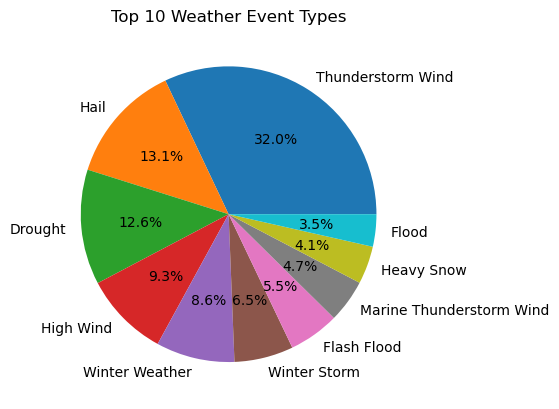

In [22]:
# Get event counts
event_counts = data.groupby('EVENT_TYPE').count().orderBy('count', ascending=False).limit(10)

# Convert to Pandas DataFrame for visualization
event_counts_pd = event_counts.toPandas()

# Create a pie chart
plt.pie(event_counts_pd['count'], labels=event_counts_pd['EVENT_TYPE'], autopct='%1.1f%%')
plt.title('Top 10 Weather Event Types')
plt.show()


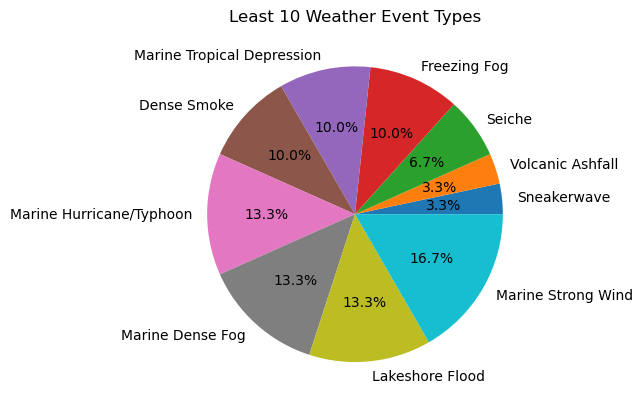

In [23]:
# Get event counts
event_counts = data.groupby('EVENT_TYPE').count().orderBy('count').limit(10)

# Convert to Pandas DataFrame for visualization
event_counts_pd = event_counts.toPandas()

# Create a pie chart
plt.pie(event_counts_pd['count'], labels=event_counts_pd['EVENT_TYPE'], autopct='%1.1f%%')
plt.title('Least 10 Weather Event Types')
plt.show()

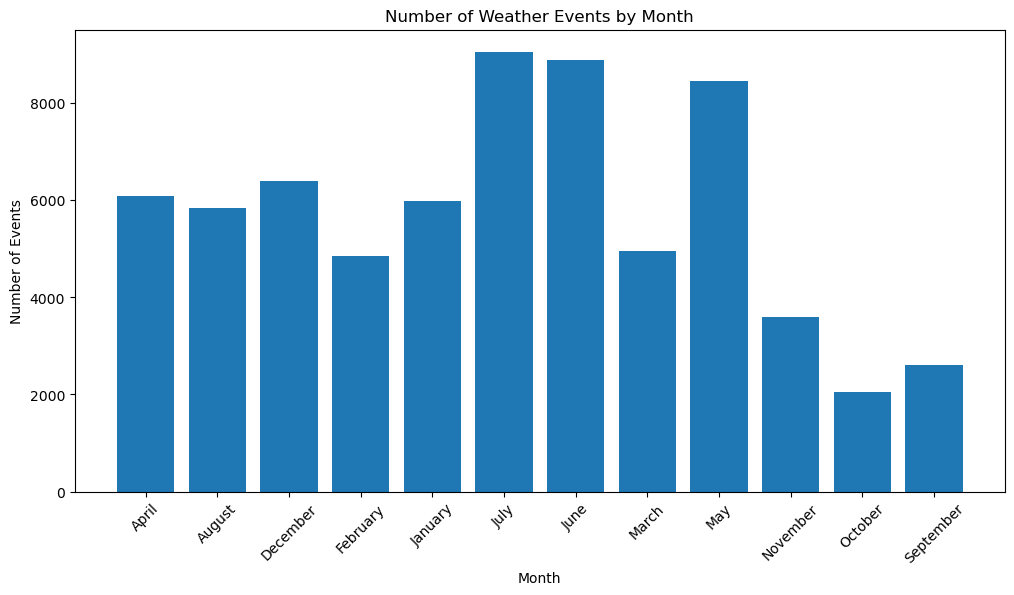

In [24]:
# Group data by month name and count occurrences
event_counts = data.groupBy("MONTH_NAME").count().orderBy(col("MONTH_NAME"))

# Convert to Pandas DataFrame for visualization
event_counts_pd = event_counts.toPandas()

# Plot a bar chart of the event counts
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(event_counts_pd["MONTH_NAME"], event_counts_pd["count"])

# Set the title and axis labels
ax.set_title("Number of Weather Events by Month")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Events")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

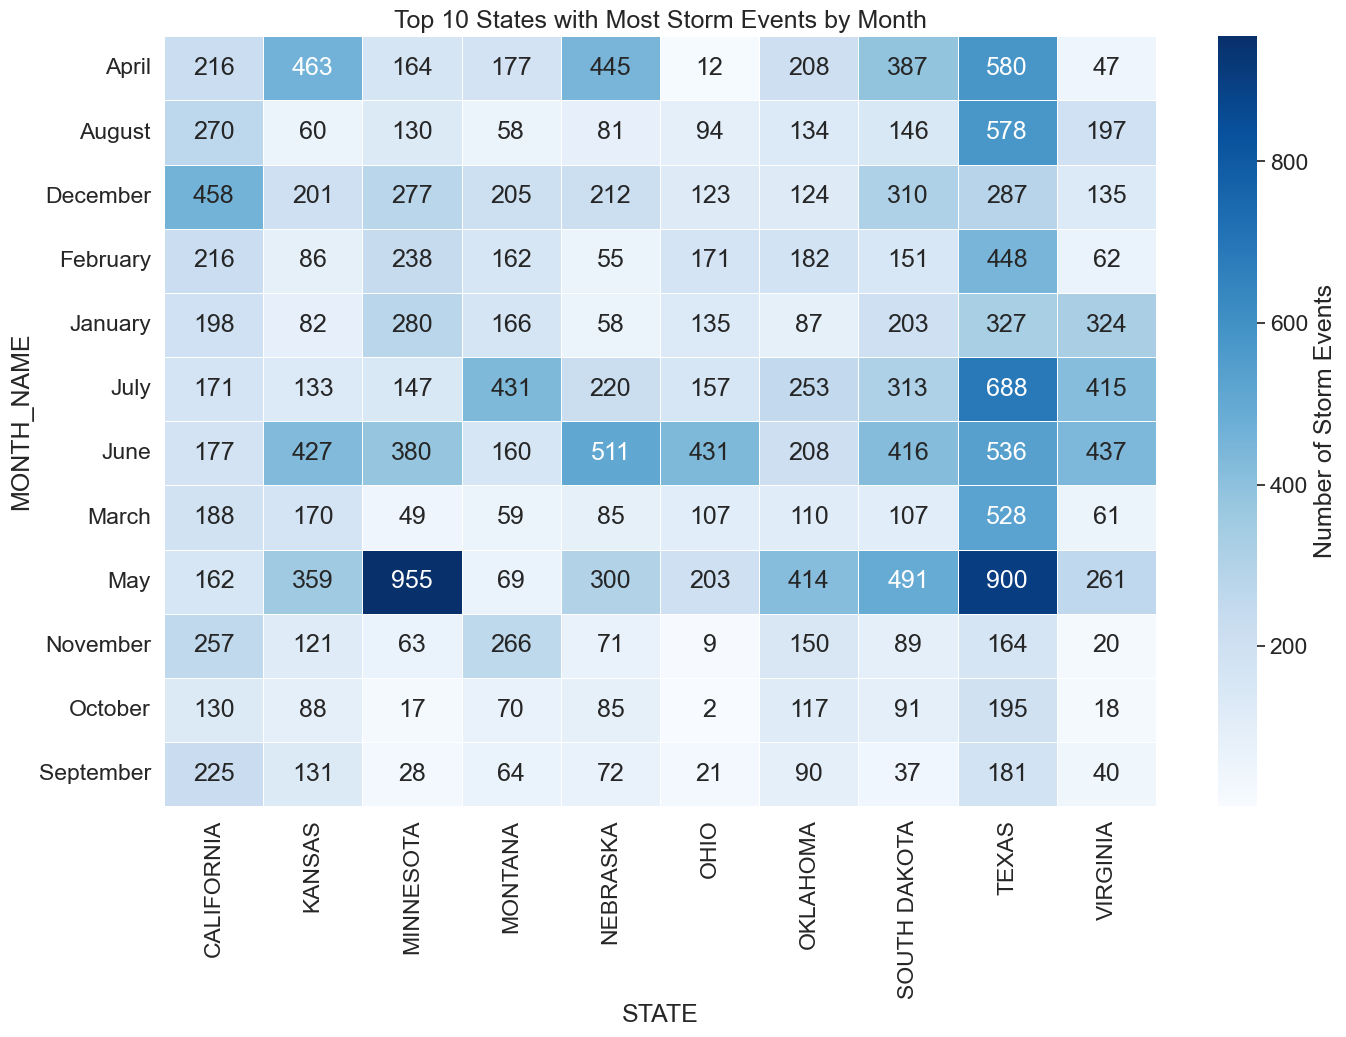

In [25]:
import seaborn as sns

# Group the data by 'STATE' and 'MONTH_NAME', and count the number of storm events
data_heatmap = data.groupBy('STATE', 'MONTH_NAME').count()

# Convert the data to Pandas DataFrame for visualization
data_heatmap_pd = data_heatmap.toPandas()

# Sort the data_heatmap_pd DataFrame by count in descending order
data_heatmap_pd_sorted = data_heatmap_pd.sort_values('count', ascending=False)

# Get the top 10 states
top_10_states = data_heatmap_pd_sorted['STATE'].head(20).tolist()

# Filter the data_heatmap_pd DataFrame for the top 10 states
data_heatmap_top_10 = data_heatmap_pd_sorted[data_heatmap_pd_sorted['STATE'].isin(top_10_states)]

# Create a pivot table for the heatmap
data_heatmap_pivot = data_heatmap_top_10.pivot('MONTH_NAME', 'STATE', 'count')

# Create the heatmap using seaborn
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.heatmap(data_heatmap_pivot, cmap='Blues', annot=True, fmt='g', linewidths=.5, cbar_kws={'label': 'Number of Storm Events'})
plt.title('Top 10 States with Most Storm Events by Month')
plt.show()

## Exploring Storm Events Clustering using KMeans

Using "Begin Day" and "End Day" as features for K-means and Bisecting Kmeans clustering can provide insights into the temporal patterns or trends in storm events. Here are a few reasons why it can be beneficial:

1. **Capture seasonal patterns**: By including the "Begin Day" and "End Day" columns, the clustering algorithm can identify patterns related to specific times of the year. For example, it can group storms that commonly occur during certain seasons or months.



2. **Identify recurring patterns**: The clustering algorithm can discover clusters of storm events that exhibit similar temporal patterns. It can help identify recurring patterns such as storms that tend to occur on specific days of the week or specific times of the day.



3. **Detect changes over time**: By analyzing the clusters formed by the algorithm, we can observe changes in storm patterns over time. This information can be valuable for understanding climate patterns, identifying shifts in storm behavior, or detecting any long-term changes in storm occurrence.



4. **Support decision-making**: Clustering storm events based on "Begin Day" and "End Day" can provide useful information for decision-making processes. For example, it can help emergency management agencies allocate resources based on the expected temporal distribution of storms or assist in planning response strategies for specific time periods.

Overall, using "Begin Day" and "End Day" as features for K-means/Bisecting KMeans clustering allows for the exploration and identification of temporal patterns in storm events, which can provide valuable insights for various applications related to weather analysis, disaster management, and decision support systems.

In [26]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

In [27]:
# Select the relevant columns for clustering
cols = ['BEGIN_DAY', 'END_DAY']
data = data.select(cols)

In [28]:
# Split the data into training and validation sets
train_data, val_data = data.randomSplit([0.8, 0.2], seed=42)

In [29]:
# Assemble the features into a single column
assembler = VectorAssembler(inputCols=cols, outputCol="features")
assembled_train = assembler.transform(train_data)

In [30]:
# Assemble the features into a single column for validation set
assembled_val = assembler.transform(val_data)

In [31]:
# Train KMeans clustering model
kmeans = KMeans(k=5, seed=42)
model = kmeans.fit(assembled_train)

In [32]:
# Make predictions on validation set
predictions = model.transform(assembled_val)

In [33]:
# Evaluate the model
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(predictions)
print(f"Silhouette score on validation set: {silhouette_score:.3f}")

Silhouette score on validation set: 0.772


In [34]:
# Make predictions on training set
predictions_train = model.transform(assembled_train)

In [35]:
# Evaluate the model on training set
silhouette_score_train = evaluator.evaluate(predictions_train)
print(f"Silhouette score on training set: {silhouette_score_train:.3f}")

Silhouette score on training set: 0.772


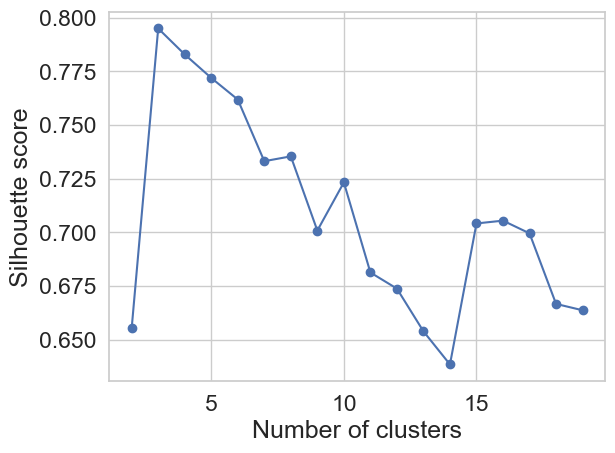

In [36]:
# Try different numbers of clusters
scores = []
for n_clusters in range(2, 20):
    kmeans = KMeans(k=n_clusters, seed=42)
    model = kmeans.fit(assembled_train)
    predictions = model.transform(assembled_val)
    score = evaluator.evaluate(predictions)
    scores.append(score)

# Plot the elbow curve
plt.plot(range(2, 20), scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

## Exploring Storm Events Clustering using Bisecting KMeans

In [37]:
from pyspark.ml.clustering import BisectingKMeans

In [38]:
# Select the relevant columns for clustering
cols = ['BEGIN_DAY', 'END_DAY']

In [39]:
# Assemble the features into a single column
assembler = VectorAssembler(inputCols=cols, outputCol="features")
assembled_data = assembler.transform(data)

In [40]:
# Assemble the features into a single column for validation set
assembled_val = assembler.transform(val_data)

In [41]:
# Split the data into training and validation sets
train_data, val_data = assembled_data.randomSplit([0.8, 0.2], seed=42)

In [42]:
# Train the Bisecting K-means model
bisecting_kmeans = BisectingKMeans(k=5, seed=42)
model = bisecting_kmeans.fit(train_data)

In [43]:
# Make predictions on validation set
predictions = model.transform(assembled_val)

In [44]:
# Evaluate the model
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(predictions)
print(f"Silhouette score on validation set: {silhouette_score:.3f}")

Silhouette score on validation set: 0.690


In [45]:
# Make predictions on training set
predictions_train = model.transform(assembled_train)

In [46]:
# Evaluate the model on training set
silhouette_score_train = evaluator.evaluate(predictions_train)
print(f"Silhouette score on training set: {silhouette_score_train:.3f}")

Silhouette score on training set: 0.697


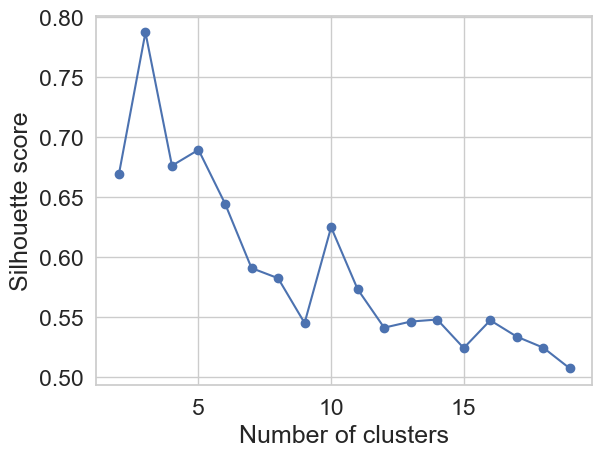

In [47]:
# Try different numbers of clusters
scores = []
for n_clusters in range(2, 20):
    bisecting_kmeans = BisectingKMeans(k=n_clusters, seed=42)
    model = bisecting_kmeans.fit(assembled_train)
    predictions = model.transform(assembled_val)
    score = evaluator.evaluate(predictions)
    scores.append(score)

# Plot the elbow curve
plt.plot(range(2, 20), scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

Based on the silhouette scores obtained, we can draw the following conclusions:

1. K-means clustering:

* The silhouette score on the validation set is 0.772, indicating a good separation and compactness of the clusters.

* The silhouette score on the training set is also 0.772, which suggests that the model generalizes well to unseen data.


2. Bisecting K-means clustering:

* The silhouette score on the validation set is 0.690, which is slightly lower compared to K-means.

* The silhouette score on the training set is 0.697, indicating a relatively good fit to the training data.


Overall, both K-means and Bisecting K-means perform reasonably well in clustering the storm events based on the given features. However, K-means shows slightly better results with higher silhouette scores on both the validation and training sets. Therefore, for this particular dataset and feature selection, K-means clustering can be considered as the preferred choice.